# What is Semantic Segmentation?

Semantic segmentation refers to the process of linking each pixel in an image to a class label. These labels could include a person, car, flower, piece of furniture, etc., just to mention a few.
We can think of semantic segmentation as image classification at a pixel level. For example, in an image that has many cars, segmentation will label all the objects as car objects. However, a separate class of models known as instance segmentation is able to label the separate instances where an object appears in an image. This kind of segmentation can be very useful in applications that are used to count the number of objects, such as counting the amount of foot traffic in a mall.

In [1]:
!pip install segmentation_models_pytorch
import time
import os
from tqdm.notebook import tqdm

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import imageio 

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.nn.functional as F

from PIL import Image
import cv2
import albumentations as A

import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 88 kB 724 kB/s eta 0:00:01
     |████████████████████████████████| 58 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 376 kB 2.7 MB/s eta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=a6f6167f14d462f2689c1774b1cd8ea640c117e2e7e113c0ed48b78136e4184a
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60963 sha256=a917b1af734fb0ad4711b48c818c7affbd92dc8379bc018fdda74d037990b6ed
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Path in Kaggle
root_img_path = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
root_mask_path = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'


# Path in Local Machine
# root_img_path = '../../input/semantic-drone-dataset/dataset/original_images/'
# root_mask_path = '../../input/semantic-drone-dataset/dataset/label_images_semantic/'

In [3]:
# Below from - https://www.kaggle.com/code/yesa911/aerial-semantic-segmentation-96-acc
image_list = os.listdir(root_img_path)
mask_list = os.listdir(root_mask_path)

image_list = [root_img_path+i for i in image_list]
mask_list = [root_mask_path+i for i in mask_list]

image_list = sorted(image_list)
mask_list = sorted(mask_list)

print("number of images is : {} ".format(len(image_list)))

print(image_list[0])
print(mask_list[0])

number of images is : 400 
../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/000.jpg
../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/000.png


(4000, 6000, 3)
(4000, 6000)


Text(0.5, 1.0, 'Mask')

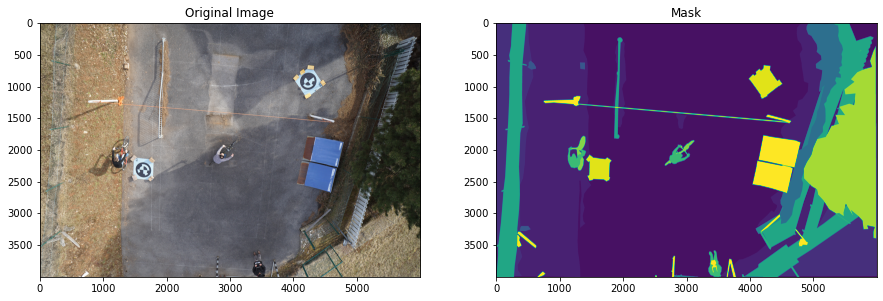

In [4]:
# Below from - https://www.kaggle.com/code/yesa911/aerial-semantic-segmentation-96-acc
n = 10 # you can chose any index 
img  = imageio.imread(image_list[n])
print(img.shape)
mask = imageio.imread(mask_list[n])
print(mask.shape)

# now let's plot 
fig ,arr  = plt.subplots(1,2,figsize=(15,10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask)
arr[1].set_title('Mask')

## For Extracting Filenames or full path from Directory 

https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

glob will return the full path and NOT only the full file names

In [5]:
# import glob
# print(glob.glob(root_img_path+"*"))

In [6]:
# for dirname, _, filenames in os.walk(root_img_path):
#     print(filenames)

In [7]:
n_classes = 23 

# def get_image_id_df():
#     name = []
#     for dirname, _, filenames in os.walk(root_img_path):
#         for filename in filenames:
#             name.append(filename.split('.')[0])
    
#     return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

# df = get_image_id_df()
# print('Total Images: ', len(df))

In [8]:
from os import listdir
from os.path import isfile, join

n_classes = 23 

# Return a df containing only the image ids
def get_image_id_df():
    name = []
    filenames = [f for f in listdir(root_img_path) if isfile(join(root_img_path, f))]
    for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = get_image_id_df()
print('Total Images: ', len(df))

Total Images:  400


In [9]:
df.head(2)

id
0  208
1  473

In [10]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


# Dataset

In [11]:
class DataGen(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)] )
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.get_img_patches(img, mask)
            
        return img, mask
   
    # Refer below for discussion around image patches in PyTorch.
    # https://discuss.pytorch.org/t/patch-making-does-pytorch-have-anything-to-offer/33850/8
    def get_img_patches(self, img, mask):
        """
        split image into smaller patches 
        """
        kh, kw = 512, 768  # kernel size
        dh, dw = 512, 768  # stride
        #for image
        img_patches = img.unfold(1, kh, dh).unfold(2, kw, dw) #tile overlap 50pixel
        
        img_patches  = img_patches.contiguous().view(3,-1, kh, kw) #change to total tile
        
        img_patches = img_patches.permute(1,0,2,3)#place the get_img_patches number in the 0 index
        
        #for mask
        mask_patches = mask.unfold(0, kh, dh).unfold(1, kw, dw)
        mask_patches = mask_patches.contiguous().view(-1, kh, kw)
        
        return img_patches, mask_patches

## Why I need patching

I have 3 dimensional data samples ranging in the 6000*4000. Such huge piece of data is too much when I fed them to the network in one piece and therefore Patching is required.

Say you want to create 64x64x64 patches out of the 500x500x500 data sample what do you guys do ?

https://discuss.pytorch.org/t/patch-making-does-pytorch-have-anything-to-offer/33850/7


-----------------------------------------

## PyTorch Official Doc on unfold

https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html

The unfold and fold are used to facilitate "sliding window" operations (like convolutions).

torch.nn.Unfold(kernel_size, dilation=1, padding=0, stride=1)[SOURCE]
Extracts sliding local blocks from a batched input tensor.

-----------------------------------------

## pytorchs fold-and-unfold

https://stackoverflow.com/questions/53972159/how-does-pytorchs-fold-and-unfold-work


`unfold` imagines a tensor as a longer tensor with repeated columns/rows of values 'folded' on top of each other, which is then "unfolded":

- `size` determines how large the folds are
- `step` determines how often it is folded

E.g. for a 2x5 tensor, unfolding it with `step=1`, and patch `size=2` across `dim=1`:

```python
x = torch.tensor([[1,2,3,4,5],
                  [6,7,8,9,10]])
```

```python
>>> x.unfold(1,2,1)
tensor([[[ 1,  2], [ 2,  3], [ 3,  4], [ 4,  5]],
        [[ 6,  7], [ 7,  8], [ 8,  9], [ 9, 10]]])
```

[![enter image description here][1]][1]

`fold` is roughly the opposite of this operation, but "overlapping" values are summed in the predicted_image.


  [1]: https://i.stack.imgur.com/uCrOg.png

-----------------------------------------

  ## `tensor.contiguous()`

  tensor.contiguous() will create a copy of the tensor, and the element in the copy will be stored in the memory in a contiguous way. 

In [12]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DataGen(root_img_path, root_mask_path, X_train, mean, std, t_train, patch=False)
val_set = DataGen(root_img_path, root_mask_path, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

# Model

In [13]:
model = smp.Unet('inceptionv4', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth" to /root/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth


  0%|          | 0.00/163M [00:00<?, ?B/s]

In [14]:
model

Unet(
  (encoder): InceptionV4Encoder(
    (features): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (3): Mixed_3a(
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
        (conv): BasicConv2d(
          (conv): Co

# Training

## Pixel Accuracy in Image Segmentation = 

###    Correctly predicted pixels divided by total number of pixels

In [15]:
def pixel_accuracy(predicted_image, mask):
    with torch.no_grad():
        predicted_image = torch.argmax(F.softmax(predicted_image, dim=1), dim=1)
        correct = torch.eq(predicted_image, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

Mean Intersection-Over-Union is a common evaluation metric for semantic image segmentation, which first computes the IOU for each semantic class and then computes the average over classes. IOU is defined as follows:

![Imgur](https://imgur.com/lTGNJKu.png)

where true-positives are those pixels that belong to the class and are correctly predicted as the class, false-negatives are those pixels that belong to the class but are incorrectly predicted as a different class 

False-positives are those pixels that belong to a different class but are predicted as the class. The image below illustrates these sets of pixels for the dog in the image above. 

### The mean IoU over the entire dataset should be calculated as follows:

1. for each class, calculate the total area_intersection and area_union over the entire dataset
2. for each class, iou = total area_intersection / total area_union
3. MIOU = mean of iou for each class



In the Difference image true-positives are indicated by yellow pixels, false-positives are indicated by red pixels and false-negatives are indicated by green pixels.

![Imgur](https://imgur.com/SsFNOBB.png)

In [16]:
def mean_iou(predicted_label, label, eps=1e-10, num_classes=10):
    with torch.no_grad():
        predicted_label = F.softmax(predicted_label, dim=1)
        predicted_label = torch.argmax(predicted_label, dim=1)

        predicted_label = predicted_label.contiguous().view(-1)
        label = label.contiguous().view(-1)

        iou_single_class = []
        for class_number in range(0, num_classes):
            true_predicted_class = predicted_label == class_number
            true_label = label == class_number

            if true_label.long().sum().item() == 0:
                iou_single_class.append(np.nan)
            else:
                intersection = (
                    torch.logical_and(true_predicted_class, true_label)
                    .sum()
                    .float()
                    .item()
                )
                union = (
                    torch.logical_or(true_predicted_class, true_label)
                    .sum()
                    .float()
                    .item()
                )

                iou = (intersection + eps) / (union + eps)
                iou_single_class.append(iou)
        return np.nanmean(iou_single_class)

In [17]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    losses_train = []
    losses_test = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; num_of_times_loss_not_improving=0

    model.to(device)
    fit_time = time.time()
    for epoch in range(epochs):
        start_time = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                batch_size, n_tiles, channel, height, width = image_tiles.size()

                image_tiles = image_tiles.view(-1,channel, height, width)
                mask_tiles = mask_tiles.view(-1, height, width)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            predicted_image = model(image)
            loss = criterion(predicted_image, mask)
            #evaluation metrics
            iou_score += mean_iou(predicted_image, mask)
            accuracy += pixel_accuracy(predicted_image, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            ''' In most of the programming languages (C/C++, Java, etc), the use of else statement has been restricted with the if conditional statements. But Python also allows us to use the else condition with for loops. The else block just after for/while is executed only when the loop is NOT terminated by a break statement. '''
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        batch_size, n_tiles, channel, height, width = image_tiles.size()

                        image_tiles = image_tiles.view(-1,channel, height, width)
                        mask_tiles = mask_tiles.view(-1, height, width)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    predicted_image = model(image)
                    #evaluation metrics
                    val_iou_score +=  mean_iou(predicted_image, mask)
                    test_accuracy += pixel_accuracy(predicted_image, mask)
                    #loss
                    loss = criterion(predicted_image, mask)                                  
                    test_loss += loss.item()
            
            # Calculate iou mean for each batch
            losses_train.append(running_loss/len(train_loader))
            losses_test.append(test_loss/len(val_loader))


            # Now check if Loss is decreasing
            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            # And if Loss NOT decreasing
            if (test_loss/len(val_loader)) > min_loss:
                num_of_times_loss_not_improving += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {num_of_times_loss_not_improving} time')
                if num_of_times_loss_not_improving == 6:
                    print('Loss not decrease for 6 times, Stop Training')
                    break
            
            # Update IoU and Accuracy list
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_iou.append(val_iou_score/len(val_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(epoch+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Validation Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mean_iou:{:.3f}..".format(iou_score/len(train_loader)),
                  "Validation mean_iou: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-start_time)/60))
        
    history = {'train_loss' : losses_train, 'val_loss': losses_test,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [18]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = train(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.022 
Epoch:1/15.. Train Loss: 2.859.. Validation Loss: 2.022.. Train mean_iou:0.075.. Validation mean_iou: 0.205.. Train Acc:0.207.. Val Acc:0.556.. Time: 5.39m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.022 >> 1.228 
Epoch:2/15.. Train Loss: 1.758.. Validation Loss: 1.228.. Train mean_iou:0.234.. Validation mean_iou: 0.318.. Train Acc:0.587.. Val Acc:0.697.. Time: 5.21m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/15.. Train Loss: 1.338.. Validation Loss: 1.340.. Train mean_iou:0.286.. Validation mean_iou: 0.289.. Train Acc:0.640.. Val Acc:0.646.. Time: 5.22m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.340 >> 1.216 
Epoch:4/15.. Train Loss: 1.235.. Validation Loss: 1.216.. Train mean_iou:0.289.. Validation mean_iou: 0.292.. Train Acc:0.639.. Val Acc:0.650.. Time: 5.24m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.216 >> 0.931 
saving model...
Epoch:5/15.. Train Loss: 1.152.. Validation Loss: 0.931.. Train mean_iou:0.307.. Validation mean_iou: 0.347.. Train Acc:0.662.. Val Acc:0.718.. Time: 5.22m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:6/15.. Train Loss: 1.001.. Validation Loss: 0.952.. Train mean_iou:0.359.. Validation mean_iou: 0.389.. Train Acc:0.711.. Val Acc:0.705.. Time: 5.20m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.952 >> 0.788 
Epoch:7/15.. Train Loss: 0.971.. Validation Loss: 0.788.. Train mean_iou:0.380.. Validation mean_iou: 0.433.. Train Acc:0.713.. Val Acc:0.773.. Time: 5.24m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.788 >> 0.723 
Epoch:8/15.. Train Loss: 0.864.. Validation Loss: 0.723.. Train mean_iou:0.407.. Validation mean_iou: 0.441.. Train Acc:0.747.. Val Acc:0.780.. Time: 5.23m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.723 >> 0.649 
Epoch:9/15.. Train Loss: 0.822.. Validation Loss: 0.649.. Train mean_iou:0.421.. Validation mean_iou: 0.453.. Train Acc:0.756.. Val Acc:0.799.. Time: 5.26m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.649 >> 0.631 
Epoch:10/15.. Train Loss: 0.777.. Validation Loss: 0.631.. Train mean_iou:0.444.. Validation mean_iou: 0.484.. Train Acc:0.770.. Val Acc:0.812.. Time: 5.27m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.631 >> 0.574 
saving model...
Epoch:11/15.. Train Loss: 0.687.. Validation Loss: 0.574.. Train mean_iou:0.459.. Validation mean_iou: 0.491.. Train Acc:0.798.. Val Acc:0.826.. Time: 5.25m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.574 >> 0.527 
Epoch:12/15.. Train Loss: 0.639.. Validation Loss: 0.527.. Train mean_iou:0.482.. Validation mean_iou: 0.516.. Train Acc:0.813.. Val Acc:0.840.. Time: 5.26m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.527 >> 0.508 
Epoch:13/15.. Train Loss: 0.579.. Validation Loss: 0.508.. Train mean_iou:0.499.. Validation mean_iou: 0.507.. Train Acc:0.830.. Val Acc:0.844.. Time: 5.28m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.508 >> 0.500 
Epoch:14/15.. Train Loss: 0.550.. Validation Loss: 0.500.. Train mean_iou:0.512.. Validation mean_iou: 0.508.. Train Acc:0.839.. Val Acc:0.848.. Time: 5.20m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:15/15.. Train Loss: 0.552.. Validation Loss: 0.508.. Train mean_iou:0.512.. Validation mean_iou: 0.512.. Train Acc:0.840.. Val Acc:0.844.. Time: 5.23m
Total time: 78.70 m


In [19]:
torch.save(model, 'InceptionV4.pt')

In [20]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_iou_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_accuracy(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

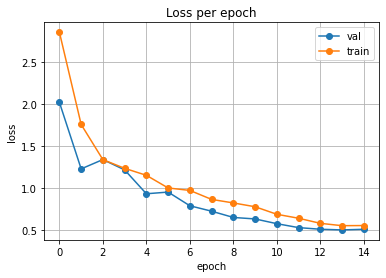

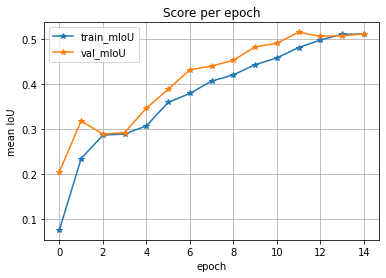

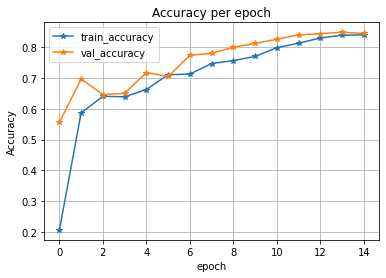

In [21]:
plot_loss(history)
plot_iou_score(history)
plot_accuracy(history)

# Evaluation

In [22]:
class TestDataLoader(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = TestDataLoader(root_img_path, root_mask_path, X_test, transform=t_test)

## Result

In [23]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        predicted_image = model(image)
        score = mean_iou(predicted_image, mask)
        masked = torch.argmax(predicted_image, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [24]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        predicted_image = model(image)
        acc = pixel_accuracy(predicted_image, mask)
        masked = torch.argmax(predicted_image, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [25]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [26]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [27]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [28]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [29]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

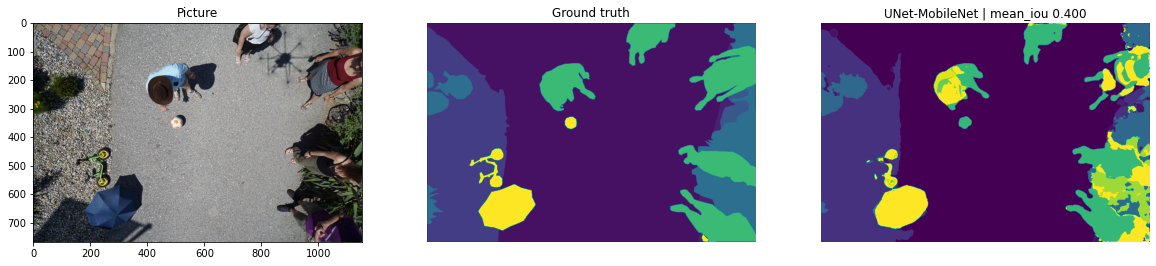

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mean_iou {:.3f}'.format(score))
ax3.set_axis_off()

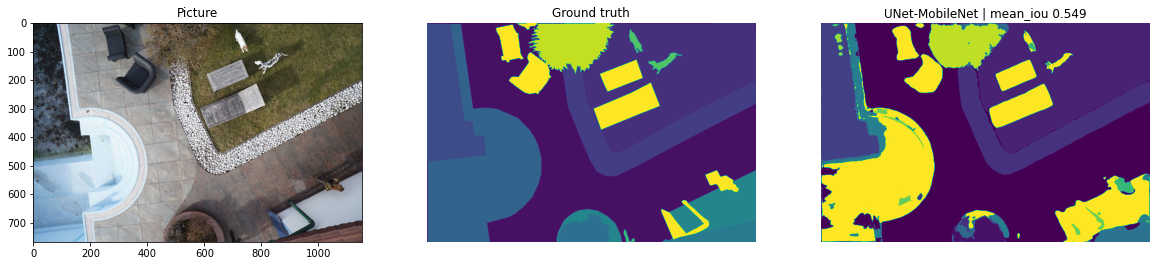

In [31]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mean_iou {:.3f}'.format(score2))
ax3.set_axis_off()

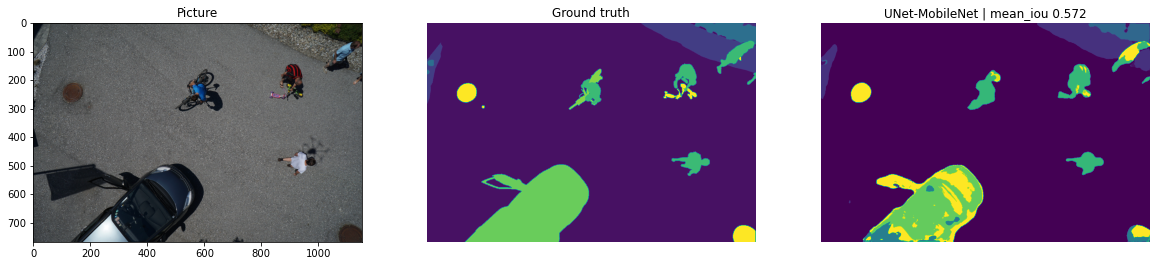

In [32]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mean_iou {:.3f}'.format(score3))
ax3.set_axis_off()

In [33]:
print('Test Set mean_iou', np.mean(mob_miou))

Test Set mean_iou 0.4862662546616767


In [34]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.8301179673936632
